# Feature selection with cross-validation

In the following, we explain how 10-fold cross-validation can be used to estimate the variance of model parameters:

* During the training phase, model parameters are fixed.
* Depending on the training data, we can get very different parameter values.
* Training set size is appropriate if parameter values are roughly the same for most training sets.
* If a model parameter has large variablility over the training sets, it cannot be trusted.

Note that for some models, comparing parameters does not make sense as the same prediction function can be achieved with many parameter values.
For instance, neural networks have permutation symmetries – predictions do not change if we change the order of neurons in hidden layers.
Thus, estimators of parameter variance make sense only for models that have compact representations – two different parameter sets determine two different predictors.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn

from pandas import Series
from pandas import DataFrame
from typing import Tuple

from tqdm import tnrange#, tqdm_notebook
from sklearn.linear_model import LogisticRegression
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Experiment setup

We again consider a relatively simple prediction task with a relatively small feature set and an impossible prediction task with the same feature set for comparison. 
We use majority voting and logistic regression as example classifiers as in the previous notebook. 

In [2]:
sampler_0 = lambda n: data_sampler(n, 8, lambda x: logit(x, Series([0, 0])))
sampler_1 = lambda n: data_sampler(n, 8, lambda x: logit(x, Series([1, 1])))
clf_1 = MajorityVoting()
clf_2 = LogisticRegression(solver = 'lbfgs')

## II. Modified cross-validation algorithm

We will use the standard cross-validation scheme but instead of measuring test and training errors, we collect model parameters:
* For majority voting, the parameter set is the prediction table.
* For logistic regression, the parameter set comprises model coefficients.

In [3]:
k = 10
m = 10
n = k * m
data = sampler_1(n)
features = list(data.columns.values[:-1])

### Function for computing cross-validation splits

In [4]:
def crossvalidation_splits(X: DataFrame, y: Series, k: int=10) -> Tuple[List[int], List[int]]:
    assert len(X) == len(y), 'Data matrix and the target vector must match'
    assert len(X) % k == 0,  'Crossvalidation is unimplemented for cases n != k * m'  
    assert X.index.equals(y.index), 'Indices of the data matrix and target vector must match'

    n = len(X)
    m = int(n/k)
    samples = np.random.permutation(X.index)
    folds = [samples[start: start + m] for start in range(0, n, m)]
    
    for i in range(k):
        training_index = [x for x in range(k) if x != i]
        training_samples = np.concatenate([folds[i] for i in training_index])
        test_samples = folds[i]
        yield (i, training_samples, test_samples)

### Way to extract coefficients of logistic regression model

Logistic regression model has coefficients $\boldsymbol{\beta}=(\beta_1,\ldots,\beta_m)$ and a free term $\beta_0$.
The following code shows how to extract them. 

In [5]:
clf_2.fit(data[features], data['y'])
print(clf_2.intercept_)
print(clf_2.coef_)

[0.65069016]
[[ 0.92898946  1.09826959 -0.35826307  0.24598722 -0.42428698 -0.74907811
   0.03565789 -1.18016491]]


In [6]:
def coeff(clf)->Series:
    assert isinstance(clf, sklearn.linear_model._logistic.LogisticRegression), "Works only for logistic regression"
    return Series(np.concatenate([clf.intercept_, clf.coef_[0]]))

In [7]:
coeff(clf_2)

0    0.650690
1    0.928989
2    1.098270
3   -0.358263
4    0.245987
5   -0.424287
6   -0.749078
7    0.035658
8   -1.180165
dtype: float64

## Coefficient variance estimates

Now we run cross-validaton to get different $\boldsymbol{\beta}$ values.

In [8]:
result = (DataFrame(index =list(range(10)))
    .reindex(columns = ['beta_{}'.format(i) for i in range(9)]))

for i, training_samples, test_samples in crossvalidation_splits(data, data['y']):
    train = data.iloc[training_samples]
    clf_2.fit(train[features], train['y'])
    result.loc[i, :] = coeff(clf_2).values
display(result)

,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8
0,0.501180,1.132738,1.148142,-0.486918,0.393587,-0.265512,-0.670154,-0.052015,-1.074861
1,0.581628,0.901615,1.273573,-0.414483,0.164354,-0.542942,-0.797289,-0.063200,-0.929926
2,1.126582,0.870001,0.760095,-0.362354,0.255797,-0.744244,-0.648599,0.091853,-1.342015
3,0.864607,0.840133,1.115931,-0.357410,0.049298,-0.492026,-0.792863,0.084514,-1.177727
4,0.728131,0.840858,1.192295,-0.370630,0.096080,-0.197875,-0.876665,-0.010521,-1.262100
5,0.516611,0.960745,1.031338,-0.278609,0.361042,-0.191895,-0.741565,0.000944,-1.212981
6,0.657647,0.645876,1.039283,-0.343469,0.165545,-0.378001,-0.723323,0.067819,-1.141309
7,0.564936,0.745729,1.077599,-0.368466,0.444184,-0.513313,-0.546825,0.109485,-1.318829
8,0.330995,1.122614,1.052608,-0.240000,0.164770,-0.444843,-0.643014,0.063958,-1.050740
9,0.548636,0.992976,1.065263,-0.264773,0.293499,-0.420792,-0.814182,0.064838,-1.048839


### Visualisation

Let's melt the data and compute $95\%$ confidence intervals.

In [9]:
df = (DataFrame(result.stack(), columns = ['value'])
      .reset_index()
      .rename(columns = {'level_0':'fold', 'level_1':'coefficient'}))
display(head(df))

sdf = (df.groupby(['coefficient'])
       .aggregate({'value': ['mean', 'std']})
       .pipe(reset_column_index, 0)
       .assign(lower_ci = lambda df: df['mean'] - 3 * df['std']/np.sqrt(10))
       .assign(upper_ci = lambda df: df['mean'] + 3 * df['std']/np.sqrt(10))
       .assign(significant = lambda df: np.sign(df['lower_ci'] * df['upper_ci']) == 1)
       .reset_index())
display(sdf)

,fold,coefficient,value
0,0,beta_0,0.501180
1,0,beta_1,1.132738
2,0,beta_2,1.148142
3,0,beta_3,-0.486918
4,0,beta_4,0.393587


,coefficient,mean,std,lower_ci,upper_ci,significant
0,beta_0,0.642095,0.221764,0.431711,0.852479,True
1,beta_1,0.905329,0.153528,0.759679,1.050978,True
2,beta_2,1.075613,0.134644,0.947878,1.203347,True
3,beta_3,-0.348711,0.073307,-0.418256,-0.279166,True
4,beta_4,0.238816,0.132092,0.113502,0.364129,True
5,beta_5,-0.419144,0.170541,-0.580933,-0.257355,True
6,beta_6,-0.725448,0.099093,-0.819456,-0.631440,True
7,beta_7,0.035767,0.061895,-0.022951,0.094486,False
8,beta_8,-1.155933,0.131893,-1.281058,-1.030808,True


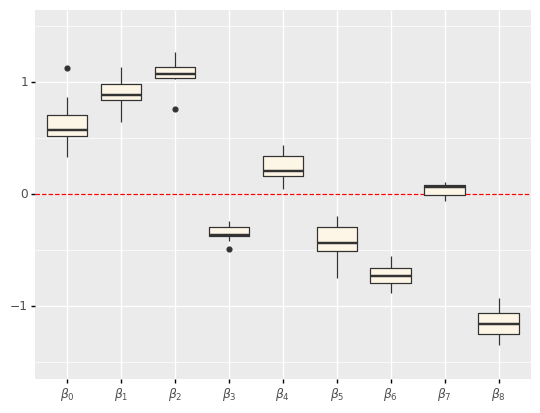

<ggplot: (351631065)>

In [10]:
p = ggplot(df)
p = p + geom_hline(yintercept = 0, color = 'red', linetype ='--')
p = p + geom_boxplot(aes(x = 'coefficient', y = 'value'), fill = 'oldlace')
p = p + scale_x_discrete(name = '', labels=[r'$\beta_{}$'.format(i) for i in range(9)])
p = p + scale_y_continuous(name = "", limits = (-1.5, 1.5))
p.save('crossvalidation_parameter_variance_i.pdf', path='results', height=6, width=6, verbose=False)
display(p)

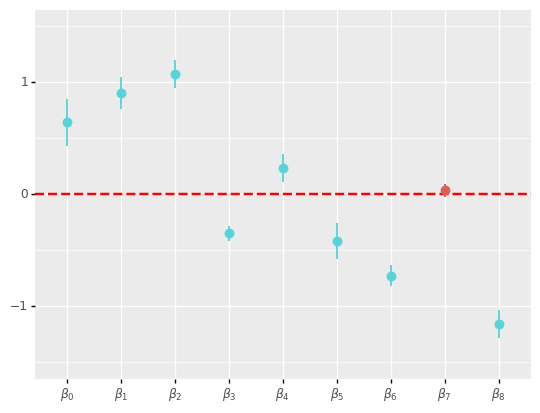

<ggplot: (352059344)>

In [11]:
p = ggplot(sdf)
p = p + geom_hline(yintercept = 0, color = 'red', linetype ='--', size = 1)
p = p + geom_pointrange(aes(x = 'coefficient', ymin = 'lower_ci', y='mean', ymax = 'upper_ci', color = 'significant'), size=0.75)
p = p + scale_x_discrete(name = '', labels=[r'$\beta_{}$'.format(i) for i in range(9)])
p = p + scale_y_continuous(name = "", limits = (-1.5, 1.5))
p = p + scale_color_discrete(guide = False)
p.save('crossvalidation_parameter_variance_ii.pdf', path='results', height=6, width=6, verbose=False)
display(p)

# Homeworks

## 5.1 Analysis of prediction stability (<font color='red'>3p</font>)

Cross-validation can be used to study the stability of a learning algorithm:

* You can study how much the coefficients of your model vary.
* You can study how fragile is your learning algorithm to noise.

Let's explore these concepts by studying the stability of polynomial regression models $y\sim x^2+x+1$ and $y\sim x^8 + x^7 + \cdots + x + 1$.

* Stability of coefficients (<font color='red'>1p</font>) 
  * Fit these models on cross-validation folds and observe regression coefficients by drawing corresponding boxplots. 
  * Study the mean and variance of individual model coefficients. Declare that a coefficient is insignificant and set it to zero when its mean is not more than 3 standard deviations away from zero. 
  * Interpret the results. Are both models similar?
  
  
* Stability of predictions (<font color='red'>1p</font>) 
  * Fit these models on cross-validation folds.
  * For each learned model, compute a prediction line in the interval $[-2,1]$.
  * Draw a faceted plot with facets for models $y\sim x^2+x+1$ and $y\sim x^8 + x^7 + \cdots + x + 1$.
  * On each subplot, plot individual prediction lines. Use `alpha=0.5` to make lines semi-transparent.
  * Draw also the average prediction line in red on the plot.


* Stability against noise (<font color='red'>1p</font>) 
  * To study robustness against noise, you can add additional Gaussian noise to $y_i$ values of training samples  and later estimate how much the mean squared error increased as a consequence. 
  * The latter should estimate how sensitive is your method to random noise.
  * Experiment with different scale values $\sigma=0.001, 0.01, 0.1, 1$, and visualise the results.
 
  

### Remarks
* Use the sampler `regr_sampler` as the data source. 
* Use [sklearn.linear_model.LinearRegression](
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) together with 
[sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to implement polynomial regression:
  * First define additional columns $x_2=x^2, \ldots, x_8=x^8$.
  * Then use linear regression to find corresponding coefficients $\beta_0,\beta_1,\ldots, \beta_8$.
* Use [numpy.random.normal](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html) to sample the additional Gaussian noise needed in the last part of the exercise.

In [ ]:
def regr_sampler(n: int) -> DataFrame:
    return (DataFrame(np.random.uniform(low=-2, high=1, size=100), columns=['x']).
            assign(y = lambda df: df['x']**2 + df['x'] + np.random.normal(scale=0.3, size=len(df))))     

,x,y
0,0.390850,0.584429
1,0.967128,1.485084
2,0.027058,0.399149
3,0.558338,0.691814
4,0.782931,1.158167
5,0.937114,1.397179
6,0.791583,1.211764
7,0.519620,0.713566
8,0.976999,1.520037
9,0.045622,0.505317


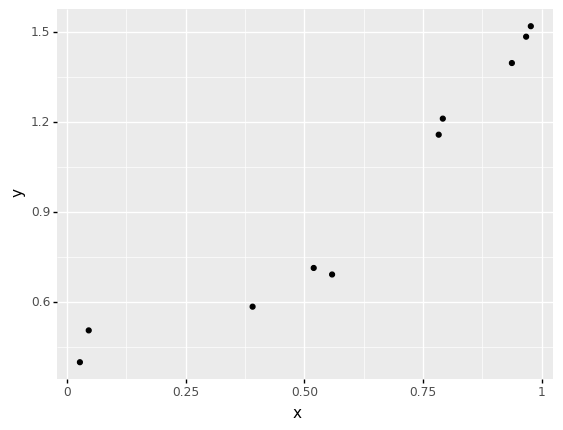

<ggplot: (352036642)>

In [13]:
data = regr_sampler(10)
display(data)
ggplot(data) + geom_point(aes(x = 'x', y='y'))

In [14]:
%config IPCompleter.greedy=True